In [54]:
import pandas as pd
import scipy.sparse as sp
import numpy as np
import json
import torch
from tqdm import tqdm

In [55]:
df_tags = pd.read_csv('./data/ml10/fold0_valid/fold0/tr_tags.csv')

rows, cols = df_tags.item, df_tags.tag
values = np.ones(len(df_tags))

m_item_keyphrase= sp.csr_matrix((values, (rows, cols)), dtype='float64')

with open('./data/ml10/tag_id_dict.json') as f:
    tag_id_dict = json.load(f)
with open('./data/ml10/title_id_dict.json') as f:
    title_id_dict = json.load(f)

id_tag_dict = {id: tag for tag, id in tag_id_dict.items()}
id_title_dict = {id: title for title, id in title_id_dict.items()}

PATH = './saves/ml10/VAE_beta_multilayer.pt'
model = torch.load(PATH, map_location=torch.device('cpu'))
item_embeddings = model.decoder.weight.detach().numpy()

from utils.KAVgenerator import KAVgenerator
k = KAVgenerator(m_item_keyphrase,item_embeddings, 1)
keyphrase_embeddings = k.get_all_mean_kav(20, 100)

100%|██████████| 164/164 [00:17<00:00,  9.38it/s](164, 100, 150)



In [56]:
from utils.Dataset import Dataset
dataset = Dataset(data_dir='./data/ml10/fold0_valid/fold0/',load_keyphrases=True)

Read data from ./data/ml10/fold0_valid/fold0/


In [57]:
def get_mu_cov(user_id, input_matrix, moddel):
    user_input = input_matrix[user_id]
    i = torch.FloatTensor(user_input.toarray()).to(torch.device('cpu'))
    with torch.no_grad():
        mu, logvar = model.get_mu_logvar(i)
    std = model.logvar2std(logvar)
    mu, std = mu.numpy().T, std.numpy()

    return mu, np.diagflat(std*std)

def update_posterior(x, y, S_0, m_0, prec_y):
    S_0_inv = np.linalg.inv(S_0)
    #S_1 = np.linalg.inv(S_0_inv +prec_y * x @ x.T)    
    #print(np.swapaxes(x,-2,-1).shape)
    S_1 = np.linalg.inv(S_0_inv +prec_y * np.matmul(x,np.swapaxes(x,-2,-1)))
    m_1 = S_1 @ (S_0_inv @ m_0 + prec_y * y * x)
    #print(m_1.shape)
    return S_1, m_1

In [58]:
# for all users:
    # compute rates
    # update
    # compute updated_rates
    # updated_rates - rates
    # separate and add
# take average

def eval_routine(keyphrase_id, keyphrase_embeddings, train_matrix, model, prec_y, is_positive):
    x = keyphrase_embeddings[keyphrase_id][:,np.newaxis]
    mask = np.array((m_item_keyphrase[:,keyphrase_id]>0).todense()).squeeze()
    pos_item_ids = mask.nonzero()[0]
    neg_item_ids = (1-mask).nonzero()[0]
    pos = []
    neg = []

    for user_id in tqdm(range(train_matrix.shape[0])):
        mu, cov = get_mu_cov(user_id, train_matrix, model)
        updated_preds = eval_subroutine(mu, cov, model, x, prec_y, is_positive)
        pos.append(np.mean(updated_preds[pos_item_ids]))
        neg.append(np.mean(updated_preds[neg_item_ids]))

    return (np.mean(pos) - np.mean(neg)) /  np.mean(neg)


def eval_subroutine(mu, cov, model, x, prec_y, is_positive):
    #_mu = torch.FloatTensor(mu.T)
    #with torch.no_grad():
    #    preds = model.decoder(_mu)
    # initial_preds = np.asarray(preds).reshape(-1)
    y = np.max(mu.T @ keyphrase_embeddings.T) if is_positive \
                    else np.min(mu.T @ keyphrase_embeddings.T)
    
    cov1, mu1 = update_posterior(x, y, cov, mu, prec_y)
    _mu = torch.FloatTensor(mu1.T)
    with torch.no_grad():
        preds = model.decoder(_mu)
    updated_preds = np.asarray(preds).reshape(-1)
    #diffs = (updated_preds - initial_preds) / np.abs(initial_preds)

    return updated_preds


In [69]:
keyphrase = 'anime'
keyphrase_id = tag_id_dict[keyphrase]

result = {'Rating Difference Rate': [], 'Precision':[], 'Direction':[]}
for prec in [0, 1, 10, 100, 1000]:
    metric = eval_routine(keyphrase_id, keyphrase_embeddings, dataset.train_matrix, model, prec, True)
    result['Rating Difference Rate'].append(metric)
    result['Precision'].append(prec)
    result['Direction'].append('Pos')
    if prec == 0:
        result['Rating Difference Rate'].append(metric)
        result['Precision'].append(prec)
        result['Direction'].append('Neg')

for prec in [1, 10, 100, 1000]:
    metric = eval_routine(keyphrase_id, keyphrase_embeddings, dataset.train_matrix, model, prec, False)
    result['Rating Difference Rate'].append(metric)
    result['Precision'].append(prec)
    result['Direction'].append('Neg')
 





100%|██████████| 69878/69878 [03:41<00:00, 314.92it/s]


In [70]:
from pathlib import Path
save_dir = Path("./saves/ml10/"+keyphrase+'.csv') 
pd.DataFrame(result).to_csv(str(save_dir), index=False)

In [71]:
a = pd.DataFrame(result)

In [72]:
a

,Rating Difference Rate,Precision,Direction
0,0.249628,0,Pos
1,0.249628,0,Neg
2,0.292707,1,Pos
3,0.370876,10,Pos
4,0.400781,100,Pos
5,0.404833,1000,Pos
6,0.199190,1,Neg
7,0.100330,10,Neg
8,0.059803,100,Neg
9,0.054194,1000,Neg


In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

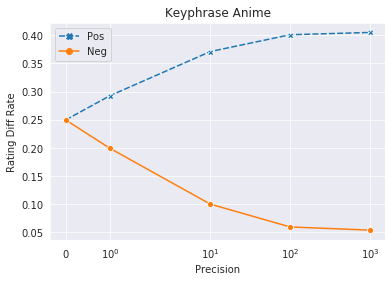

In [73]:
sns.set_style("darkgrid")
k = a.pivot("Precision", "Direction", "Rating Difference Rate")
plot = sns.lineplot(data=k, markers=True, dashes=True, hue_order=['Pos','Neg'])
plot.set_xscale('symlog')
plot.set_title('Keyphrase Anime')
plot.set_ylabel('Rating Diff Rate')
plot.figure.savefig("./saves/ml10/"+keyphrase+'.pdf')

In [46]:
k

prec,0,10,100
is_pos,,,
neg,0,-10,-100
pos,0,10,100


[Text(0, 0, '10'), Text(0, 0, '0'), Text(0, 0, '10')]

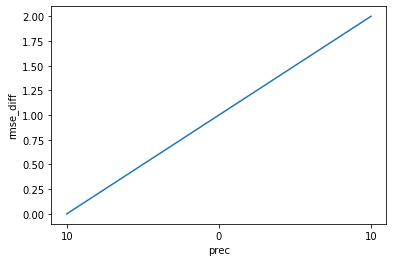

In [41]:
#g = sns.lineplot(data=a, x='prec', y='rmse_diff')
#g.set_xticks([-10,0,10])
#g.set_xticklabels(['10','0','10'])

In [6]:
id_tag_dict

{0: 'anime',
 1: 'super-hero',
 2: 'woody allen',
 3: 'comic book',
 4: 'samuel l jackson',
 5: 'brad pitt',
 6: 'bruce willis',
 7: 'time travel',
 8: 'crime',
 9: 'serial killer',
 10: 'action',
 11: 'jim carrey',
 12: 'stupid',
 13: 'dystopia',
 14: 'drama',
 15: 'aliens',
 16: 'based on a book',
 17: 'classic',
 18: 'fantasy',
 19: 'sci-fi',
 20: 'space',
 21: 'arnold schwarzenegger',
 22: 'matt damon',
 23: 'oscar (best actor)',
 24: 'oscar (best picture)',
 25: 'ghosts',
 26: 'twist ending',
 27: 'stephen king',
 28: 'tom hanks',
 29: 'interesting',
 30: 'dvd',
 31: 'nicolas cage',
 32: 'magic',
 33: 'morgan freeman',
 34: 'bond',
 35: 'music',
 36: 'gay',
 37: 'comedy',
 38: 'funny',
 39: 'alfred hitchcock',
 40: 'true story',
 41: 'family',
 42: 'film noir',
 43: 'heist',
 44: 'quirky',
 45: 'sequel',
 46: 'memory',
 47: 'psychology',
 48: 'espionage',
 49: 'satire',
 50: 'shakespeare',
 51: 'black comedy',
 52: 'adventure',
 53: 'girlie movie',
 54: 'teen',
 55: 'disney',
 56: